<a href="https://colab.research.google.com/github/ghdakrk/computr_vision/blob/main/inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

import cv2

tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
tf.__version__

'2.7.0'

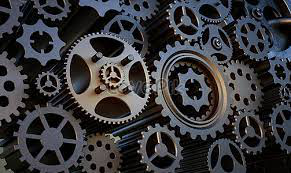

In [ ]:
# 이미지를 내려받아 넘파이 배열로 변환합니다.
def download(path, max_dim=None):
  img = PIL.Image.open(path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

def max_dim(img, max_dim=None):
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)    

# 이미지를 정규화합니다.
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# 이미지를 출력합니다.
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# 이미지의 크기를 줄여 작업이 더 용이하도록 만듭니다.
original_img = download('톱니.jfif', max_dim=800)
original_img = original_img[:,:,:3]
show(original_img)

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [ ]:
# 선택한 층들의 활성화값을 최대화합니다.
names = ['mixed3','mixed7']
layers = [base_model.get_layer(name).output for name in names]

# 특성 추출 모델을 만듭니다.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  # 이미지를 순전파시켜 모델의 활성화값을 얻습니다.
  # 이미지의 배치(batch) 크기를 1로 만듭니다.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # `img`에 대한 그래디언트가 필요합니다.
          # `GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # 입력 이미지의 각 픽셀에 대한 손실 함수의 그래디언트를 계산합니다.
        gradients = tape.gradient(loss, img)

        # 그래디언트를 정규화합니다.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # 경사상승법을 이용해 "손실" 최대화함으로써 입력 이미지가 선택한 층들을 보다 더 "흥분" 시킬 수 있도록 합니다.
        # (그래디언트와 이미지의 차원이 동일하므로) 그래디언트를 이미지에 직접 더함으로써 이미지를 업데이트할 수 있습니다.
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=5, step_size=0.03):
  # 이미지를 모델에 순전파하기 위해 uint8 형식으로 변환합니다.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [ ]:
def random_roll(img, maxroll):
  # 타일 경계선이 생기는 것을 방지하기 위해 이미지를 랜덤하게 이동합니다.
  tf.random.set_seed(0)
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # 그래디언트를 0으로 초기화합니다.
    gradients = tf.zeros_like(img_rolled)

    # 타일이 하나만 있지 않은 이상 마지막 타일은 건너뜁니다.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # 해당 타일의 그래디언트를 계산합니다.
        with tf.GradientTape() as tape:
          # `img_rolled`에 대한 그래디언트를 계산합니다.
          # ‘GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img_rolled)

          # 이미지에서 타일 하나를 추출합니다.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # 해당 타일에 대한 이미지 그래디언트를 업데이트합니다.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # 이미지와 그래디언트에 적용한 랜덤 이동을 취소합니다.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # 그래디언트를 정규화합니다.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=10, step_size=0.03, 
                                octaves=range(-2,3), octave_scale=1.3):
    tf.random.set_seed(2)
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # 옥타브에 따라 이미지의 크기를 조정합니다.
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
            # if step % 10 == 0:
            #     show(deprocess(img))
            #     print ("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result

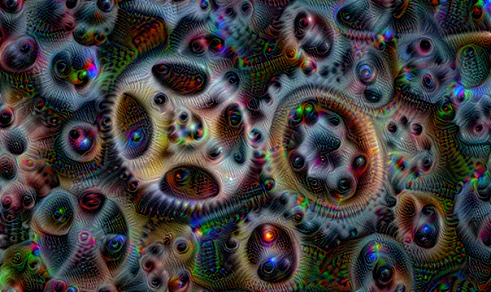

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.03)
base_shape = tf.shape(img)[:-1]
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

In [ ]:
def trans_img(img):
    img = run_deep_dream_with_octaves(img=img, step_size=0.03)
    base_shape = tf.shape(img)[:-1]
    img = tf.image.resize(img, base_shape)
    img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
    return img

In [ ]:
def cnt_frame(video):
    cap = cv2.VideoCapture(video)
    cnt = 0
    while(cap.isOpened()):
        ret, img = cap.read()
        # n프레임당 사진 추출
        # frame = 10
        if ret == True:
            cnt += 1
        else:
            break
    return cnt

In [ ]:
def trans_video(video, frame, imgs):
    total = cnt_frame(video)
    cap = cv2.VideoCapture(video)
    cnt = 0
    while(cap.isOpened()):
        ret, img = cap.read()
        if ret == True:
            if cap.get(1) % frame == 0:
                img = PIL.Image.fromarray(img)
                img = max_dim(img, 500)[:,:,:3]
                imgs.append(trans_img(img))
            if  cap.get(1) % 50 == 0:
                print(f"현재 완성도 : {round(100*cap.get(1)/total)}%")
        else:
            break

In [ ]:
def trans_video3(video, frame, imgs):
    total = cnt_frame(video)
    cap = cv2.VideoCapture(video)
    cnt = 0
    while(cap.isOpened()):
        ret, img = cap.read()
        if ret == True:
            if cap.get(1) % frame in [1,2,3]:
                img = PIL.Image.fromarray(img)
                img = max_dim(img, 500)[:,:,:3]
                imgs.append(trans_img(img))
            else:
                img = PIL.Image.fromarray(img)
                img = max_dim(img, 500)[:,:,:3]
                base_shape = tf.shape(img)[:-1]
                img = tf.image.resize(img, base_shape)
                img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
                imgs.append(img)
            if  cap.get(1) % 50 == 0:
                print(f"현재 완성도 : {round(100*cap.get(1)/total)}%")
        else:
            break

In [ ]:
# 일부프레임만 변화 주어 생동감과 현실을 왔다갔다하게
def trans_video2(video, frame, imgs):
    total = cnt_frame(video)
    cap = cv2.VideoCapture(video)
    cnt = 0
    while(cap.isOpened()):
        ret, img = cap.read()
        if ret == True:
            if cap.get(1) == 1:
                img = PIL.Image.fromarray(img)
                img = max_dim(img, 500)[:,:,:3]
                img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
                show(trans_img(img))
            if  cap.get(1) % 50 == 0:
                print(f"현재 완성도 : {round(100*cap.get(1)/total)}%")
        else:
            break

In [ ]:
 trans_video2('시리얼.mp4', 1, imgs)

In [ ]:
cnt_frame('시리얼.mp4')

273

In [ ]:
imgs=[]
trans_video3('시리얼.mp4', 10, imgs)

현재 완성도 : 18%
현재 완성도 : 37%
현재 완성도 : 55%
현재 완성도 : 73%
현재 완성도 : 92%


In [ ]:
# img_arr = [np.array(img) for img in imgs]
img_arr = [np.array(img)for img in imgs]
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
width, heighgt = imgs[0].shape[0], imgs[0].shape[1]
# 중요!! width, height 순서를 바꿔야함
out = cv2.VideoWriter('시리얼.avi', fourcc, 15, frameSize=(heighgt, width))

for img in img_arr:
    out.write(img)
out.release()

In [ ]:
from google.colab import files
files.download('시리얼.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>